In [6]:
#import pystan nevermind no general interpolation function
import pymc3 as pm
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import splat
from scipy import interpolate, integrate
import theano.tensor as tt
from theano.compile.ops import as_op
from scipy.interpolate import griddata
import wisps
import wisps.simulations as wispsim
import theano
import splat.empirical as spe

In [ ]:
import tqdm import tqdm_notebook

### Purpose: Make UCD evolutionary models interpolations in pymc

**Towards a full Bayesian hierchical modelling of UCD mass function**

Rough graphical model
- $\alpha$ ~ Uniform
- M &larr; Powerlaw($\alpha$)
- Age ~ Uniform
- Teff &larr; (M, Age)


In [7]:
#modelfile='../splines.stan'
datafile='/users/caganze/desktop/burrows2001.csv'
burrows=pd.read_csv(datafile)

In [8]:
import astropy.units as u

In [10]:
Rsun=8300.
Zsun=27.
SPGRID=np.arange(0, 100)
AREA=((4.1*385.+626.1)*(u.arcmin**2)).to((u.radian)**2) 
SOLID_ANGLE=((np.sin(np.sqrt(AREA)))**2.0).value
pnts=wisps.OBSERVED_POINTINGS
LBS=np.vstack([[x.coord.galactic.l.radian,x.coord.galactic.b.radian] for x in pnts ])

In [11]:

@as_op(itypes=[tt.dscalar, tt.dscalar], otypes=[tt.dscalar])
def custom_interpolation_mass_age(mass, age):
    """
    Interpolation function using burrow's models and scipy interpolate
    All this wrapped in theano tensors 
    
    Input: mass, age
    Output: teff
    """
    points=np.array([burrows.mass.values, burrows.age.values]).T
    valuest=burrows.temperature.values
    #valueslogg=burrows.gravity.values
    teff = griddata(points,valuest , (mass, age), method='linear')
    #logg = griddata(points,valueslogg , (mass, age), method='linear')
    return  teff

@as_op(itypes=[tt.dscalar], otypes=[tt.dscalar])
def splat_teff_to_spt(teff):
    """
    Interpolatiom function using the Pecaut relation
    Input: teff
    Output: SpT
    """
    rel=splat.SPT_TEFF_RELATIONS['pecaut']
    spt_sorted_idx=np.argsort(rel['values'])
    spt=np.interp(teff, np.array(rel['values'])[spt_sorted_idx], np.array(rel['spt'])[spt_sorted_idx])

    return spt


def observed(spt):
    return np.nanmean([x for x in OBSERVED.values()])


In [12]:
from theano.ifelse import ifelse

In [197]:
def logprior(l, b):
        return tt.switch(( abs(b) < 0.35),-np.inf, 0)

def loglike(r, z, d, h):
    return np.log10((d**2)*density_function(r, z, h))

#-------------------------------------------
def density_function(r, z, h):
    
    """
    A custom juric density function that only uses numpy arrays for speed
    All units are in pc
    """
    l = 2600. # radial length scale of exponential thin disk 
    zpart=np.exp(-abs(z-Zsun)/h)
    rpart=np.exp(-(r-Rsun)/l)
    return zpart*rpart

def log_mass_function(m, alpha):
    return np.log(m**-alpha)

def chi_square(val, pred):
    #our chisquare
    return -(val-pred)**2

def logp(l, b, r, z, d, h, m, alpha):
    return (np.log((d**2)*density_function(r, z, h)))+log_mass_function(m, alpha)



In [193]:
with pm.Model() as model:
    
    #velocity paremeters
    v10 = 41.899
    tau1 = 0.001
    beta = 0.307
    
    v10_v = 28.823
    tau_v = 0.715
    beta_v = 0.430
    
    v10_w = 23.381
    tau_w = 0.001
    beta_w = 0.445
    
    k = 74.
    
    #priors on mass function and age
    alpha=pm.Uniform('alpha', lower=0.0, upper=2.0, observed=.6)
    m=pm.Uniform('m', lower=np.nanmin(burrows.mass.values), upper=0.15, testval=0.005)
    age=pm.Uniform('age', lower=np.nanmin(burrows.age.values), upper=np.nanmax(burrows.age.values), observed=2.)
    
    #interpolations
    teff=pm.Deterministic('teff', custom_interpolation_mass_age(m, age))  
    
    #velocities
    sigma_u =pm.Deterministic('sigma_u',  v10*((age+tau1)/(10.+tau1))**beta)
    uvel =pm.Normal('uvel', mu=0.0, sigma=sigma_u)

    sigma_v = pm.Deterministic('sigma_v', v10_v*((age+tau_v)/(10.+tau_v))**beta_v)
    
    voff = -1.*(sigma_v**2)/k
    vvel = pm.Normal('vvel', mu=voff,sigma=sigma_v)
    
    sigma_w = pm.Deterministic('sigma_w', v10_w*((age+tau_w)/(10.+tau_w))**beta_w)
    wvel = pm.Normal('wvel', mu=0., sigma=sigma_w)

    #galactic structure from velocity dispersion
    sigma_tot=pm.Deterministic('sigma_tot', (sigma_w**2+sigma_u**2+sigma_v**2)**0.5)
    
    h=pm.Deterministic('h',(217/68)*(sigma_tot**2)/20.0)
    
    l=pm.Uniform('l', lower=-np.pi, upper=np.pi, testval=np.pi/2)
    b=pm.Uniform('b', lower=-np.pi/2, upper=np.pi/2, testval=np.pi/3)
    
    d=pm.Uniform('d', lower=0., upper=10000., testval=500.)
    x=pm.Deterministic('x',  Rsun-d*np.cos(b)*np.cos(l))
    y=pm.Deterministic('y', -d*np.cos(b)*np.sin(l))
    r=pm.Deterministic('r', (x**2+y**2)**0.5 )
    z=pm.Deterministic('z', Zsun+ d * np.sin(b))

    
    #likelihood
    like = pm.DensityDist('likelihood', logp, observed={'l':l, 'b':b,
                         'r': r, 'z': z, 'd':d, 'h':h, 'm':m, 'alpha':alpha})


    trace = pm.sample(draws=1000, cores=2,step=None, init='advi',  start=None, 
                      trace=None, chain_idx=0, chains=None,
                      tune=500, progressbar=True, model=None,
                      random_seed=None, discard_tuned_samples=True, compute_convergence_checks=False)

    
    



Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average Loss = -12.281:  35%|███▌      | 70072/200000 [00:51<01:36, 1351.90it/s]  
Convergence achieved at 70100
Interrupted at 70,099 [35%]: Average Loss = -9.3123
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [d, b, l, wvel, vvel, uvel, m]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:29<00:00, 102.77draws/s]


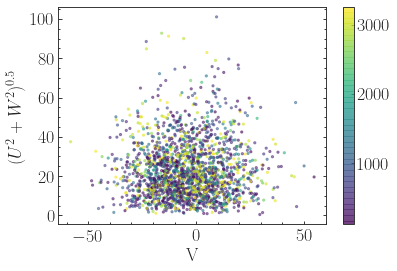

In [194]:
fig, ax=plt.subplots()
c=plt.scatter( trace.vvel,  (trace.uvel**2+trace.wvel**2)**0.5, c=trace.teff, s=5.,
              cmap='viridis', alpha=0.5)
ax.set_xlabel('V', fontsize=18)
ax.set_ylabel(r'$(U^2+W^2)^{0.5}$', fontsize=18)
plt.minorticks_on()
plt.colorbar(c)

In [195]:
kde1=wisps.kernel_density([trace.r, trace.z])
kde2=wisps.kernel_density([trace.x, trace.y])

dens1=kde1.pdf([trace.r, trace.z])
dens2=kde2.pdf([trace.x, trace.y])

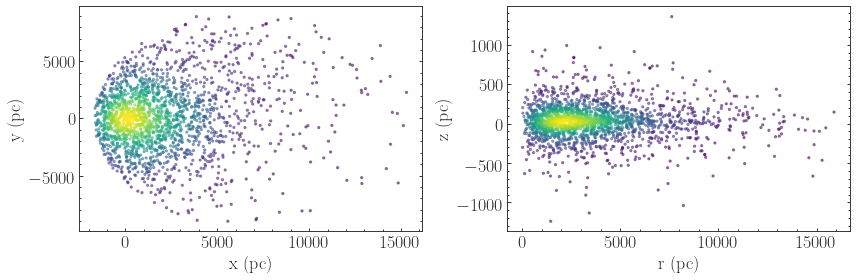

In [196]:
fig, ax=plt.subplots(ncols=2, figsize=(12, 4))
c=ax[0].scatter(trace.x, trace.y, c=dens2, s=5.,  alpha=0.5, cmap='viridis')
ax[0].set_xlabel('x (pc)', fontsize=18)
ax[0].set_ylabel('y (pc)', fontsize=18)

c=ax[1].scatter(trace.r, trace.z, c=dens1, s=5.,  alpha=0.5, cmap='viridis')
ax[1].set_xlabel('r (pc)', fontsize=18)
ax[1].set_ylabel('z (pc)', fontsize=18)

ax[0].minorticks_on()
ax[1].minorticks_on()

plt.tight_layout()

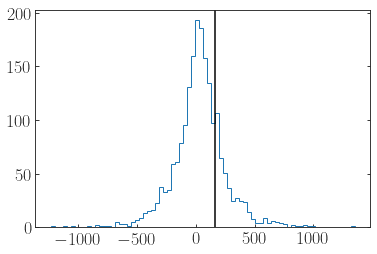

In [203]:
h=plt.hist(trace.z, bins='auto', histtype='step')
plt.axvline(trace.h.mean(), c='k')

In [204]:
200/50

4.0